The other Notebook became a bit much, so I'll be working on visualisations in this Notebook, copying the main functions from `MR-analyse-proximus-mobility-data.ipynb`

# Calculating baseline $P^{gh}$

In [30]:
import datetime
# import pandas as pd
import numpy as np
import glob
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
import datetime
# sys.path.insert(0, "../tools")
from covid19model.data.mobility import * # contains all necessary functions
from covid19model.visualization.output import *

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

agg='arr'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from datetime import date, datetime, timedelta
# import pandas as pd
import numpy as np
import glob
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
import datetime
# sys.path.insert(0, "../tools")
from covid19model.data.mobility import * # contains all necessary functions
from covid19model.visualization.output import *
from covid19model.data.sciensano import get_sciensano_COVID19_data_spatial

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Import Sciensano data
sciensano_df = get_sciensano_COVID19_data_spatial(agg='arr', values='hospitalised_IN', moving_avg=True).sum(axis=1)
sciensano_values= sciensano_df.values
sciensano_dates = sciensano_df.index + pd.Timedelta(hours=12)

<IPython.core.display.Javascript object>


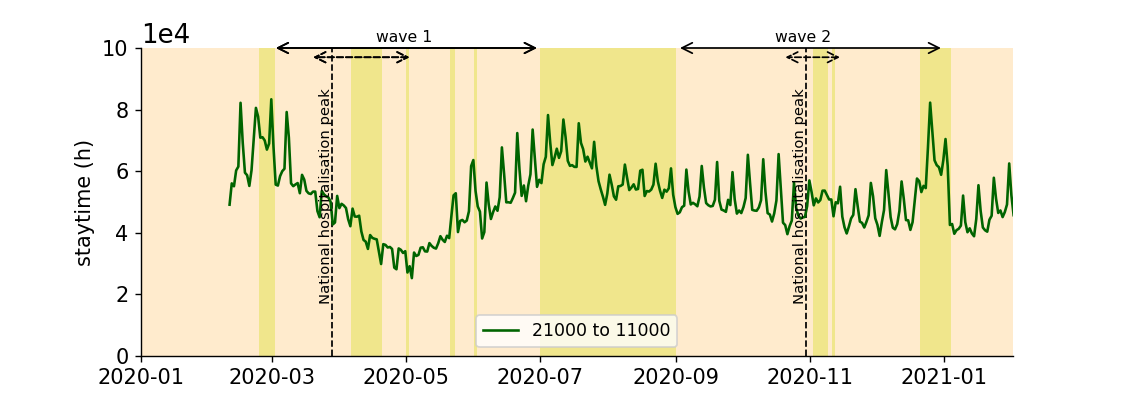

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Text(2020-10-24 00:00:00, 18000, 'National hospitalisation peak')

In [83]:
# start_date = datetime.datetime(2020, 1, 1, 0, 0)
# # end_date = datetime.datetime(2021, 9, 1, 0, 0)
# end_date = datetime.datetime(2021, 2, 1, 0, 0)
# start_calibration_wave1 = pd.Timestamp(2020, 3, 5, 0, 0)
# end_calibration_wave1 = pd.Timestamp(2020, 8, 7, 0, 0)
# start_calibration_wave2 = pd.Timestamp(2020, 9, 1, 0, 0)
# end_calibration_wave2 = pd.Timestamp(2021, 2, 1, 0, 0)

# fig, ax = plt.subplots(figsize=(9,3))
# ax.grid(False)
# ax.set_xlim(start_date, end_date)
# ymin, ymax = (0, 400000000/60/60)
# ax.set_ylim(ymin, ymax)
# color_timeframes(start_date, end_date, ax=ax)
# # ax.set_title('test', size=14)

# # Add shading denoting calibration periods
# arrows = False
# if arrows:
#     label_cal_size = 9
#     label_cal_move_up = (ymax-ymin)*0.015
#     arrow_height = ymax
#     ax.annotate(s='', xy=(start_calibration_wave1,arrow_height), xytext=(end_calibration_wave1,arrow_height), \
#                 arrowprops=dict(arrowstyle='<->'))
#     label_cal1_move_right = 44 # days
#     ax.text(start_calibration_wave1 + pd.Timedelta(days=label_cal1_move_right), \
#             ymax + label_cal_move_up, 'calibration wave 1', size=label_cal_size)

#     ax.annotate(s='', xy=(start_calibration_wave2,arrow_height), xytext=(end_calibration_wave2,arrow_height), \
#                 arrowprops=dict(arrowstyle='<->'))
#     label_cal2_move_right = 41 # days
#     ax.text(start_calibration_wave2 + pd.Timedelta(days=label_cal2_move_right), \
#             ymax + label_cal_move_up, 'calibration wave 2', size=label_cal_size)

# ticklabelsize = 12
# plt.setp(ax.get_xticklabels(), Fontsize=ticklabelsize)
# plt.setp(ax.get_yticklabels(), Fontsize=ticklabelsize)

# plt.xticks(rotation=20)

############################
# Copied from timeline.pdf #
############################

show_lockdown = True
show_waves = True
show_asc_desc = True

t1 = pd.Timestamp(2020, 1, 10, 0, 0) # First death in China
t1_name = 'First death reported by Chinese officials'
t2 = pd.Timestamp(2020, 2, 3, 0, 0) # First case in BE
t2_name = 'First clinically diagnosed case in Belgium'
t3 = pd.Timestamp(2020, 3, 10, 0, 0) # First death in BE. Two more follow day after.
t3_name = 'First death in Belgium'
t4 = pd.Timestamp(2020, 3, 18, 0, 0) # Begin lockdown
t4_name = 'Begin first Belgian lockdown'
t5 = pd.Timestamp(2020, 5, 4, 0, 0) #
t5_name = 'Lockdown exit: phase 1'
t6 = pd.Timestamp(2020, 5, 19, 0, 0) #
t6_name = 'Lockdown exit: phase 2'
t7 = pd.Timestamp(2020, 6, 4, 0, 0) #
t7_name = 'Lockdown exit: phase 3'
t8 = pd.Timestamp(2020, 7, 1, 0, 0)
t8_name = 'Start of Summer holidays'
t9 = pd.Timestamp(2020, 8, 1, 0, 0)
t9_name = 'Lockdown in Antwerp province'
t9p1 = pd.Timestamp(2020, 9, 1, 0, 0)
t9p1_name = 'Re-opening primary/secondary schools'
t10 = pd.Timestamp(2020, 10, 19, 0, 0)
t10_name = 'Begin second Belgian lockdown'
t11 = pd.Timestamp(2020, 11, 16, 0, 0)
t11_name = 'Re-opening primary/secondary schools'
t12 = pd.Timestamp(2020, 12, 19, 0, 0)
t12_name = 'Start of Winter holidays'
t13 = pd.Timestamp(2021, 1, 4, 0, 0)
t13_name = 'Re-opening primary/secondary schools'

tm1 = pd.Timestamp(2020, 3, 28, 0, 0)
tm1_name = 'National hospitalisation peak'

tm2 = pd.Timestamp(2020, 10, 30, 0, 0)
tm2_name = 'National hospitalisation peak'

start_date = datetime.datetime(2020, 1, 1, 0, 0)
end_date = datetime.datetime(2021, 2, 1, 0, 0)
fig, ax = plt.subplots(figsize=(9,3.2))
ax.grid(False)
ticklabelsize = 12
ax.set_xlim(start_date, end_date)
ylim=1e5
ax.set_ylim(0, ylim)
plt.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
# Overlay hospitalisations
ax.grid(False)
ax.set_ylabel('Staytime (h)', size=ticklabelsize)
plt.setp(ax.get_xticklabels(), Fontsize=ticklabelsize)
# ax.plot(sciensano_dates, sciensano_values, linewidth=2, color='maroon', alpha=0.7)
plt.setp(ax.get_yticklabels(), Fontsize=ticklabelsize)

week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=ax, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
# ax.set_title('test', size=14)

# Add arrows denoting lockdown periods
if show_lockdown:
    label_lockdown_size = 9
    label_lockdown_move_up = 20
    arrow_height = ylim -3e3
    # First lockdown
    ax.annotate(text='', xy=(t4, arrow_height), xytext=(t5,arrow_height), \
                arrowprops=dict(arrowstyle='<->', ls='dashed'))
    label_lockdown1_move_right = 7 # days
    # ax.text(t4 + pd.Timedelta(days=label_lockdown1_move_right), \
    #         ylim + label_lockdown_move_up, 'lockdown', size=label_lockdown_size)
    ax.annotate(text='', xy=(t4, arrow_height), xytext=(t5,arrow_height), \
                arrowprops=dict(arrowstyle='<->', ls='dashed'))
    # second lockdown
    label_lockdown1_move_right = -2.5 # days
    # ax.text(t10 + pd.Timedelta(days=label_lockdown1_move_right), \
    #         ylim + label_lockdown_move_up, 'lockdown', size=label_lockdown_size)
    ax.annotate(text='', xy=(t10, arrow_height), xytext=(t11,arrow_height), \
                arrowprops=dict(arrowstyle='<->', ls='dashed'))

# ax.annotate(text='', xy=(start_calibration_wave2,arrow_height), xytext=(end_calibration_wave2,arrow_height), \
#             arrowprops=dict(arrowstyle='<->'))
# label_cal2_move_right = 41 # days
# ax.text(start_calibration_wave2 + pd.Timedelta(days=label_cal2_move_right), \
#         ymax + label_cal_move_up, 'calibration wave 2', size=label_cal_size)

if show_waves:
    ti_wave1 = pd.Timestamp(2020, 3, 1, 0, 0)
    tm_wave1 = pd.Timestamp(2020, 3, 28, 0, 0)
    tf_wave1 = pd.Timestamp(2020, 7, 1, 0, 0)
    ti_wave2 = pd.Timestamp(2020, 9, 1, 0, 0)
    tm_wave2 = pd.Timestamp(2020, 10, 30, 0, 0)
    tf_wave2 = pd.Timestamp(2021, 1, 1, 0, 0)
    label_waves_size = 9
    label_waves_move_up = 2e3
    arrow_height = ylim
    # First wave
    ax.annotate(text='', xy=(ti_wave1, arrow_height), xytext=(tf_wave1,arrow_height), \
                arrowprops=dict(arrowstyle='<->'))
    label_wave1_move_right = 47 # days
    ax.text(ti_wave1 + pd.Timedelta(days=label_wave1_move_right), \
            ylim + label_waves_move_up, 'wave 1', size=label_waves_size)
    ax.annotate(text='', xy=(ti_wave1, arrow_height), xytext=(tf_wave1,arrow_height), \
                arrowprops=dict(arrowstyle='<->'))
    # second wave
    label_wave2_move_right = 45 # days
    ax.text(ti_wave2 + pd.Timedelta(days=label_wave2_move_right), \
            ylim + label_waves_move_up, 'wave 2', size=label_waves_size)
    ax.annotate(text='', xy=(ti_wave2, arrow_height), xytext=(tf_wave2,arrow_height), \
                arrowprops=dict(arrowstyle='<->'))

# Add vertically dashed lines
linestyle='--'
color='k'
linewidth=1
label_size = 8.5
label_height = 18000
label_move_left = 6 #5.5 # days

# peak wave 1
ax.axvline(tm1, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(tm1-pd.Timedelta(days=label_move_left), label_height, tm1_name, rotation=90, size=label_size)

# peak wave 2
ax.axvline(tm2, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(tm2-pd.Timedelta(days=label_move_left), label_height, tm2_name, rotation=90, size=label_size)

# ax.axvline(t2, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t2-pd.Timedelta(days=label_move_left), label_height, t2_name, rotation=90, size=label_size)

# ax.axvline(t3, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t3-pd.Timedelta(days=label_move_left), label_height, t3_name, rotation=90, size=label_size)

# ax.axvline(t4, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t4-pd.Timedelta(days=label_move_left), label_height, t4_name, rotation=90, size=label_size)

# ax.axvline(t5, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t5-pd.Timedelta(days=label_move_left), label_height, t5_name, rotation=90, size=label_size)

# ax.axvline(t6, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t6-pd.Timedelta(days=label_move_left), label_height, t6_name, rotation=90, size=label_size)

# ax.axvline(t7, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t7-pd.Timedelta(days=label_move_left), label_height, t7_name, rotation=90, size=label_size)

# ax.axvline(t8, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t8-pd.Timedelta(days=label_move_left), label_height, t8_name, rotation=90, size=label_size)

# ax.axvline(t9, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t9-pd.Timedelta(days=label_move_left), label_height, t9_name, rotation=90, size=label_size)

# ax.axvline(t9p1, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t9p1-pd.Timedelta(days=label_move_left), label_height, t9p1_name, rotation=90, size=label_size)

# ax.axvline(t10, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t10-pd.Timedelta(days=label_move_left), label_height, t10_name, rotation=90, size=label_size)

# ax.axvline(t11, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t11-pd.Timedelta(days=label_move_left), label_height, t11_name, rotation=90, size=label_size)

# ax.axvline(t12, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t12-pd.Timedelta(days=label_move_left), label_height, t12_name, rotation=90, size=label_size)

# ax.axvline(t13, linestyle=linestyle, color=color, linewidth=linewidth)
# ax.text(t13-pd.Timedelta(days=label_move_left), label_height, t13_name, rotation=90, size=label_size)

# plt.savefig('timeline_introduction_new_waves.png', dpi=400, bbox_inches='tight')

In [46]:
# First load the data and inspect the mobility for this date range

filename = 'absolute-mobility-matrix_staytime_' + agg + '_'
data_location = '../../data/interim/mobility/' + agg + '/staytime/'

dates_proximus=[]
dates_proximus_datetime=[]

# Define date range
# sdate_prelockdown = datetime(2020, 2, 10, 0, 0)   # start date
# edate_prelockdown = datetime(2020, 3, 15, 0, 0)   # end date
delta = end_date - start_date     # as timedelta

# Fill arrays with YYYYMMDD dates and datetime dates
for i in range(delta.days + 1):
    day = start_date + datetime.timedelta(days=i)
    dates_proximus_datetime.append(day)
    dates_proximus.append(date_to_YYYYMMDD(day))
    
# Load dictionary with YYYYMMDD dates as keys and P-matrices as values
mmprox, missing_dates = load_Pmatrix_staytime(dates_proximus, data_location, \
                                        complete=False, verbose=True, return_missing=True, agg=agg)

# date array for xaxis (takes care of missing dates: needs same number of elements in array!)
dates_proximus_xaxis = dates_proximus_datetime.copy()
for d in missing_dates:
    dates_proximus_xaxis.remove(date_to_YYYYMMDD(d, inverse=True))

... proceeding with 356 dates.
Loaded dataframe for date 20210201.    


In [84]:
NIS_from = 21000
NIS_to = 11000
fractions = []
staytime = []
# for key in mmprox:
#     fractions.append(mmprox[key].loc[str(NIS_from), str(NIS_to)])

for key in mmprox:
    staytime.append(mmprox[key].loc[str(NIS_from), str(NIS_to)]/60/60)
    
# ax.plot(np.array(dates_proximus_xaxis)+datetime.timedelta(days=0.5), 100*np.array(fractions), color='darkgreen', linewidth=1.5, label=f'{NIS_from} to {NIS_to}')
# ax.set_ylabel('% time spent', size=ticklabelsize)
ax.plot(np.array(dates_proximus_xaxis)+datetime.timedelta(days=0.5), np.array(staytime), color='darkgreen', linewidth=1.5, label=f'{NIS_from} to {NIS_to}')
ax.set_ylabel('staytime (h)', size=ticklabelsize)
ax.legend(fontsize = ticklabelsize-2, loc='lower center')#, bbox_to_anchor=(0.27, 1))

plt.savefig(f'proximus_time-spent_{NIS_from}-to-{NIS_to}.png', dpi=400, bbox_inches='tight')

In [43]:
max(staytime)

83352.21774846454

**Add hospitalisations**

In [5]:
# Import Sciensano data
from covid19model.data.sciensano import get_sciensano_COVID19_data_spatial, get_sciensano_COVID19_data
# sciensano_df = get_sciensano_COVID19_data_spatial(agg='arr', values='hospitalised_IN', moving_avg=True).sum(axis=1)
sciensano_df = get_sciensano_COVID19_data(update=False)['H_in']
sciensano_values= sciensano_df.values
sciensano_dates = sciensano_df.index

ax2=ax.twinx()
ax2.grid(False)
ax2.plot(sciensano_dates, sciensano_values, linewidth=2, color='maroon', alpha=0.7, label='national')
ax2.set_ylabel('new daily hospitalisations', size=ticklabelsize)

# ax2.legend(fontsize = ticklabelsize-2, loc='upper right', bbox_to_anchor=(1, 0.90))

# plt.savefig(f'proximus_time-spent_{NIS_from}-to-{NIS_to}_with-hospitalisations.png', dpi=400, bbox_inches='tight')

C:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


In [49]:
get_sciensano_COVID19_data?